# Keypoint Classifier V3 and VideoMAE Classifier V1

Idea now: Use pytorch's image encoders and feature extraction

https://pytorch.org/vision/stable/io.html#images

https://pytorch.org/vision/stable/feature_extraction.html



implemented from:
https://medium.com/howtoai/video-classification-with-cnn-rnn-and-pytorch-abe2f9ee031

https://github.com/PacktPublishing/PyTorch-Computer-Vision-Cookbook/blob/master/Chapter10/myutils.py



To do:

*   Run basic classifier using mediapipe and regular data
*   Try to run using VideoMAE output



In [62]:
import os
import shutil
import pandas as pd
import numpy as np
from numpy import asarray
import cv2 as cv
import re
import math
from subprocess import check_call, PIPE, Popen
import shlex

In [63]:
import torch
import torchvision
import torchvision.transforms as transforms
from PIL import Image
from torchvision import models
from torch import nn
import torcheval
from torcheval.metrics.functional import multiclass_auprc

## 1 Read Test, Train, and Val set

In [64]:
upperlimit = 500
cutoff = 406

In [65]:
train = pd.read_pickle("data/noor2/CorpusNGT/train_cutoff{}_upperlimit{}.pkl".format(cutoff, upperlimit))
test  = pd.read_pickle("data/noor2/CorpusNGT/test_cutoff{}_upperlimit{}.pkl".format(cutoff, upperlimit))
val   = pd.read_pickle("data/noor2/CorpusNGT/validate_cutoff{}_upperlimit{}.pkl".format(cutoff, upperlimit))

In [66]:
tr = (train["id"]).unique() ## So there are 157 classes in this dataset of which each have about
va = (val["id"]).unique()
te = (test["id"]).unique()
total = np.concatenate((tr, va, te), axis=0, out=None)
total = np.unique(total)
total = np.sort(total)
print(len(total))
print(len(train))                ## 156.5 instances per class on average.

20
7477


In [67]:
catgs = total
num_classes = len(catgs)
labels_dict = {}
ind = 0
for uc in catgs:
    labels_dict[uc] = ind
    ind+=1

def preprocess_datasubset(split):
    split_labels = split["id"].tolist()
    split_ids = split["path"].tolist()
    print(len(split_ids), len(split_labels))
    return split_ids, split_labels

train_ids, train_labels = preprocess_datasubset(train)
test_ids, test_labels = preprocess_datasubset(test)
val_ids, val_labels = preprocess_datasubset(val)

7477 7477
936 936
934 934


In [68]:
print(labels_dict)

{'1-A': 0, 'AL': 1, 'BINNEN': 2, 'GEBAREN-A': 3, 'GEHANDICAPT-A': 4, 'GOED-A': 5, 'HEE': 6, 'HOREN-A': 7, 'JA-A': 8, 'KIJKEN-A': 9, 'KUNNEN-A': 10, 'LAAT-MAAR': 11, 'MAAR': 12, 'PO': 13, 'POPT': 14, 'PT': 15, 'PV': 16, 'SAMEN-A': 17, 'ZELF': 18, 'ZELFDE-A': 19}


In [69]:
# We've now obtained the paths and labels for all sets of gloss frames that have two or more occurrences of the gloss, and split these into a test and training set

## 2 DEFINE DATASETS AND TRANSFORMS

In [70]:
# Now we have to transform the frames into usable format; tensors

In [73]:
from torch.utils.data import Dataset, DataLoader, Subset
import glob
from PIL import Image
import torch
import numpy as np
import random
from torchvision.transforms.functional import to_pil_image
import matplotlib.pylab as plt
torch.set_printoptions(sci_mode=False, precision=4)  # No scientific notation, 4 decimal places

np.random.seed(2024)
random.seed(2024)
torch.manual_seed(2024)

In [74]:
# Choose model type, this is just a test. For now we pick the R3D_18 ResNet 18 layer model from pytorch that has been pretrained on the Kinetics dataset

#model_type = "Net"
#model_type = "GRU"
model_type = "LSTM"

data_type = "keyppoint"
#data_type = "videoMAE"

batch_size = 32

h, w = 96, 2 # 75 keypoints x and y so 75 by 2.
h, w = 400, 1
# already normalized by mp so no mean needed

##### Old

##### verder

In [75]:
class KeyPointDataset(Dataset):
    def __init__(self, ids, labels, transform, num_keypoints=96):
        self.transform = transform
        self.ids = ids
        self.labels = labels
        self.num_keypoints = num_keypoints  # Fixed number of keypoints per frame

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        # Load the keypoint file
        keypointfile = pd.read_pickle(glob.glob(self.ids[idx] + "/keypoints")[0], compression='infer', storage_options=None)
        keypointfile = keypointfile[["frame", "x", "y"]]
        label = labels_dict[self.labels[idx]]  # Map the label

        # Group by frames and take only the first 8 frames
        framelist = list(keypointfile.groupby(by="frame"))[:8]

        frames = []
        for frame in framelist:
            frame_np = frame[1][["x", "y"]].to_numpy()

            # Pad or truncate each frame to num_keypoints
            if frame_np.shape[0] > self.num_keypoints:  # Truncate
                frame_np = frame_np[:self.num_keypoints, :]
            elif frame_np.shape[0] < self.num_keypoints:  # Pad with zeros
                padding = np.zeros((self.num_keypoints - frame_np.shape[0], frame_np.shape[1]))
                frame_np = np.vstack((frame_np, padding))

            frames.append(frame_np)

        # Ensure all 8 frames are present, pad with zero frames if necessary
        while len(frames) < 8:
            frames.append(np.zeros((self.num_keypoints, 3)))

        # Convert frames to tensors and stack them
        frames = torch.tensor(frames, dtype=torch.float32)  # Shape: [8, 96, 3]

        return frames, label

class VideoMAEDataset(Dataset):
    def __init__(self, ids, labels, transform, num_features=400):
        self.transform = transform
        self.ids = ids
        self.labels = labels
        self.num_features = num_features  # Fixed number of keypoints per frame

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        # Load the keypoint file
        loaded_features = np.load(self.ids[idx] + "/VideoMAE_Features.npz")["features"]
        loaded_features = torch.tensor(loaded_features)  # Convert back to torch if needed
        label = labels_dict[self.labels[idx]]  # Map the label
        loaded_features = normalize(loaded_features).to(torch.float32)

        return loaded_features, label

def normalize(x):
    return 2 * (x - x.min()) / (x.max() - x.min()) - 1  # Scale to [-1,1] to avoid vanishing or exploding gradients.


In [76]:
# define helper functions

def transform_keypoint_frames(frames, model_type="Net"):
    h, w = 96, 2
    # already normalized by mp

    test_transformer = transforms.Compose([
                torch.from_numpy()]
        )

    frames_tr = []
    for frame in frames:
        frame = frame
        frame_tr = test_transformer(frame)
        frames_tr.append(frame_tr)
    imgs_tensor = torch.stack(frames_tr)
    
    return imgs_tensor

def denormalize(x_, mean, std):
    x = x_.clone()
    for i in range(3):
        x[i] = x[i]*std[i]+mean[i]
    x = to_pil_image(x)
    return x

TRAIN

In [77]:
mean = [0.43216, 0.394666, 0.37645]
std = [0.22803, 0.22145, 0.216989]

train_transformer = transforms.Compose([
            transforms.Resize((h,w)),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomAffine(degrees=0, translate=(0.1,0.1)),
            transforms.ToTensor(),
            transforms.Normalize(mean, std),
            ])

train_transformer_keypoints = transforms.Compose([
            transforms.ToTensor()
            ])

train_transformer_videoMAE = transforms.Compose([
            ])


train_ds = KeyPointDataset(ids= train_ids, labels= train_labels, transform= train_transformer_keypoints)
print(len(train_ds))

# train_ds = VideoMAEDataset(ids= train_ids, labels= train_labels, transform=train_transformer_videoMAE)
# print(len(train_ds))

print(train_ds)

7477


In [78]:
# inspect
imgs, label = train_ds[10]
print(imgs)

imgs.shape, label, torch.mean(imgs), torch.max(imgs)

tensor([[[0.5425, 0.3772],
         [0.5406, 0.4243],
         [0.5389, 0.4059],
         ...,
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000]],

        [[0.5421, 0.3743],
         [0.5395, 0.4222],
         [0.5381, 0.4032],
         ...,
         [0.3539, 0.6430],
         [0.3715, 0.6481],
         [0.3792, 0.6540]],

        [[0.5408, 0.3715],
         [0.5379, 0.4243],
         [0.5372, 0.4012],
         ...,
         [0.3373, 0.6305],
         [0.3549, 0.6347],
         [0.3680, 0.6414]],

        ...,

        [[0.5352, 0.3719],
         [0.5338, 0.4345],
         [0.5316, 0.3965],
         ...,
         [0.3319, 0.5684],
         [0.3420, 0.5852],
         [0.3463, 0.6059]],

        [[0.5369, 0.3763],
         [0.5320, 0.4389],
         [0.5293, 0.4035],
         ...,
         [0.3330, 0.5804],
         [0.3411, 0.5966],
         [0.3433, 0.6152]],

        [[0.5316, 0.3754],
         [0.5264, 0.4392],
         [0.5231, 0.4068],
         ...,
 

(torch.Size([8, 96, 2]), 10, tensor(0.4656), tensor(1.0607))

In [79]:
%matplotlib inline

# ## For image condition and keypoints
# plt.figure(figsize=(10,10))
# for ii,img in enumerate(imgs[::1]):
#     plt.subplot(2,9,ii+1)
#     plt.imshow(denormalize(img, mean, std))
#     plt.title(label)

## For videoMAE
print(imgs)


tensor([[[0.5425, 0.3772],
         [0.5406, 0.4243],
         [0.5389, 0.4059],
         ...,
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000]],

        [[0.5421, 0.3743],
         [0.5395, 0.4222],
         [0.5381, 0.4032],
         ...,
         [0.3539, 0.6430],
         [0.3715, 0.6481],
         [0.3792, 0.6540]],

        [[0.5408, 0.3715],
         [0.5379, 0.4243],
         [0.5372, 0.4012],
         ...,
         [0.3373, 0.6305],
         [0.3549, 0.6347],
         [0.3680, 0.6414]],

        ...,

        [[0.5352, 0.3719],
         [0.5338, 0.4345],
         [0.5316, 0.3965],
         ...,
         [0.3319, 0.5684],
         [0.3420, 0.5852],
         [0.3463, 0.6059]],

        [[0.5369, 0.3763],
         [0.5320, 0.4389],
         [0.5293, 0.4035],
         ...,
         [0.3330, 0.5804],
         [0.3411, 0.5966],
         [0.3433, 0.6152]],

        [[0.5316, 0.3754],
         [0.5264, 0.4392],
         [0.5231, 0.4068],
         ...,
 

TEST and VAL

In [80]:
test_transformer = transforms.Compose([
            transforms.Resize((h,w)),
            transforms.ToTensor(),
            transforms.Normalize(mean, std),
            ])

test_transformer_keypoints = transforms.Compose([
            transforms.ToTensor()
            ])

test_transformer_videoMAE = transforms.Compose([
            ])

test_ds = KeyPointDataset(ids= test_ids, labels= test_labels, transform= test_transformer_keypoints)
print(len(test_ds))
val_ds = KeyPointDataset(ids= val_ids, labels= val_labels, transform= test_transformer_keypoints)
print(len(val_ds))

# test_ds = VideoMAEDataset(ids= test_ids, labels= test_labels, transform=test_transformer_videoMAE)
# print(len(test_ds))
# val_ds = VideoMAEDataset(ids= val_ids, labels= val_labels, transform=test_transformer_videoMAE)
# print(len(val_ds))

print(test_ds)

936
934


In [81]:
# total_min = 0
# total_max = 0
# for imgs, label in train_ds:
#     min = torch.min(imgs)
#     max = torch.max(imgs)
#     if min < total_min: 
#         total_min = min
#     if max > total_max:
#         total_max = max

# print(total_min)
# print(total_max)

In [82]:
imgs, label = test_ds[5]
imgs.shape, label, torch.min(imgs), torch.max(imgs)

(torch.Size([8, 96, 2]), 10, tensor(0.2850), tensor(1.0511))

In [83]:
# For keypoint or image
# plt.figure(figsize=(10,10))
# for ii,img in enumerate(imgs[::1]):
#     plt.subplot(2,9,ii+1)
#     plt.imshow(denormalize(img, mean, std))
#     plt.title(label)

## 3 DEFINE DATALOADER

We define the custom dataloader for our model; batch and stack the images etc

In [84]:
def collate_fn(batch):
    imgs_batch, label_batch = list(zip(*batch))
    imgs_batch = [imgs for imgs in imgs_batch if len(imgs)>0]
    label_batch = [torch.tensor(l) for l, imgs in zip(label_batch, imgs_batch) if len(imgs)>0]
    imgs_tensor = torch.stack(imgs_batch)
    # if data_type == "image":
    #     imgs_tensor = torch.transpose(imgs_tensor, 2, 1)
    labels_tensor = torch.stack(label_batch)
    return imgs_tensor,labels_tensor


train_dl = DataLoader(train_ds, batch_size= batch_size,
                      shuffle=True, collate_fn= collate_fn)
test_dl = DataLoader(test_ds, batch_size= batch_size,
                     shuffle=False, collate_fn= collate_fn)
val_dl = DataLoader(val_ds, batch_size= batch_size,
                     shuffle=False, collate_fn= collate_fn)

In [85]:
for xb,yb in train_dl:
    print(xb.shape, yb.shape)
    break

torch.Size([32, 8, 96, 2]) torch.Size([32])


In [86]:
for xb,yb in test_dl:
    print(xb.shape, yb.shape)
    break

torch.Size([32, 8, 96, 2]) torch.Size([32])


In [87]:
for xb,yb in val_dl:
    print(xb.shape, yb.shape)
    break

torch.Size([32, 8, 96, 2]) torch.Size([32])


## 4 DEFINE MODEL

In [88]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [89]:
## Here a we create out own network

import torchvision
import torch.nn as nn
import torch.nn.functional as F

"""
Implementation of a test model that we name "Net"
"""

class Net(nn.Module):
    #Initial testing model
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=8, out_channels=64, kernel_size=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(48 * 8 * 8, 480)
        self.fc2 = nn.Linear(480, 120)
        self.fc3 = nn.Linear(120, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [90]:
###  LSTM AND GRU for KEYPOINTS

import torch
import torch.nn as nn
import torch.nn.functional as F

if data_type == "keyppoint":
    
    """
    Implementation of LSTM
    Reference: SIGN LANGUAGE RECOGNITION WITH LONG SHORT-TERM MEMORY    https://github.com/0aqz0/SLR/blob/master/models/RNN.py
    """
    class LSTM(nn.Module):
        def __init__(self, lstm_input_size=96, lstm_hidden_size=512, lstm_num_layers=3,
                    num_classes=num_classes, hidden1=256, drop_p=0.0, pretrained=False):
            super(LSTM, self).__init__()
            # network params
            self.lstm_input_size = 96*2
            self.lstm_hidden_size = 512
            self.lstm_num_layers = lstm_num_layers
            self.num_classes = num_classes
            self.hidden1 = hidden1
            self.drop_p = drop_p
    
            # network architecture
            self.lstm = nn.LSTM(
                input_size=self.lstm_input_size,
                hidden_size=self.lstm_hidden_size,
                num_layers=self.lstm_num_layers,
                batch_first=True,
            )
            self.drop = nn.Dropout2d(p=self.drop_p)
            self.fc1 = nn.Linear(self.lstm_hidden_size, self.hidden1)
            self.fc2 = nn.Linear(self.hidden1, self.num_classes)
    
        def forward(self, x):
            batch_size, frames, height, width = x.shape
            x = x.view(batch_size, frames, -1)  # Flatten height and width dimensions
            self.lstm.flatten_parameters()
            # batch first: (batch, seq, feature)
            out, (h_n, c_n) = self.lstm(x, None)
            out = F.relu(self.fc1(out[:, -1, :]))
            out = F.dropout(out, p=self.drop_p, training=self.training)
            out = self.fc2(out)
    
            return out
    
    
    """
    Implementation of GRU
    """
    class GRU(nn.Module):
        def __init__(self, gru_input_size=96, gru_hidden_size=512, gru_num_layers=3,
                    num_classes=100, hidden1=256, drop_p=0.0, pretrained=False):
            super(GRU, self).__init__()
            # network params
            self.gru_input_size = 96*2
            self.gru_hidden_size = 512
            self.gru_num_layers = gru_num_layers
            self.num_classes = num_classes
            self.hidden1 = hidden1
            self.drop_p = drop_p
    
            # network architecture
            self.gru = nn.GRU(
                input_size=self.gru_input_size,
                hidden_size=self.gru_hidden_size,
                num_layers=self.gru_num_layers,
                batch_first=True,
            )
            self.drop = nn.Dropout2d(p=self.drop_p)
            self.fc1 = nn.Linear(self.gru_hidden_size, self.hidden1)
            self.fc2 = nn.Linear(self.hidden1, self.num_classes)
    
        def forward(self, x):
            batch_size, frames, height, width = x.shape
            x = x.view(batch_size, frames, -1)  # Flatten height and width dimensions
            self.gru.flatten_parameters()
            # batch first: (batch, seq, feature)
            out, hidden = self.gru(x, None)
            out = F.relu(self.fc1(out[:, -1, :]))
            out = F.dropout(out, p=self.drop_p, training=self.training)
            out = self.fc2(out)
    
            return out


In [91]:
if data_type == "videoMAE":
    
    class LSTM(nn.Module):
        def __init__(self, lstm_input_size=400, lstm_hidden_size=512, lstm_num_layers=3,
                    num_classes=100, hidden1=256, drop_p=0.0, pretrained=False):
            super(LSTM, self).__init__()
            # network params
            self.lstm_input_size = 400
            self.lstm_hidden_size = 512
            self.lstm_num_layers = lstm_num_layers
            self.num_classes = num_classes
            self.hidden1 = hidden1
            self.drop_p = drop_p
    
            # network architecture
            self.lstm = nn.LSTM(
                input_size=self.lstm_input_size,
                hidden_size=self.lstm_hidden_size,
                num_layers=self.lstm_num_layers,
                batch_first=True,
            )
            self.drop = nn.Dropout(p=self.drop_p)
            self.fc1 = nn.Linear(self.lstm_hidden_size, self.hidden1)
            self.fc2 = nn.Linear(self.hidden1, self.num_classes)
    
        def forward(self, x):
            batch_size = x.size(0)  # Batch size
            seq_len = 1  # Single timestep as input (no sequence)
            x = x.view(batch_size, seq_len, -1)  # Reshape to (batch_size, seq_len, feature_dim)
    
            self.lstm.flatten_parameters()
            # batch first: (batch, seq, feature)
            out, (h_n, c_n) = self.lstm(x, None)  # Pass through LSTM
            out = F.relu(self.fc1(out[:, -1, :]))  # Get last output
            out = F.dropout(out, p=self.drop_p, training=self.training)  # Apply dropout
            out = self.fc2(out)  # Final output layer
    
            return out


    class GRU(nn.Module):
        def __init__(self, gru_input_size=400, gru_hidden_size=512, gru_num_layers=3,
                    num_classes=100, hidden1=256, drop_p=0.0, pretrained=False):
            super(GRU, self).__init__()
            # network params
            self.gru_input_size = 400
            self.gru_hidden_size = 512
            self.gru_num_layers = gru_num_layers
            self.num_classes = num_classes
            self.hidden1 = hidden1
            self.drop_p = drop_p
    
            # network architecture
            self.gru = nn.GRU(
                input_size=self.gru_input_size,
                hidden_size=self.gru_hidden_size,
                num_layers=self.gru_num_layers,
                batch_first=True,
            )
            self.drop = nn.Dropout(p=self.drop_p)
            self.fc1 = nn.Linear(self.gru_hidden_size, self.hidden1)
            self.fc2 = nn.Linear(self.hidden1, self.num_classes)
    
        def forward(self, x):
            batch_size = x.size(0)  # Batch size
            seq_len = 1  # Single timestep as input (no sequence)
            x = x.view(batch_size, seq_len, -1)  # Reshape to (batch_size, seq_len, feature_dim)
    
            self.gru.flatten_parameters()
            # batch first: (batch, seq, feature)
            out, hidden = self.gru(x, None)  # Pass through GRU
            out = F.relu(self.fc1(out[:, -1, :]))  # Get last output
            out = F.dropout(out, p=self.drop_p, training=self.training)  # Apply dropout
            out = self.fc2(out)  # Final output layer
    
            return out


In [92]:
## CHANGE MODEL ARCH HERE

if model_type == "LSTM":
    params_model={
        "num_classes": num_classes,
        "drop_p": 0.0,
        "pretrained" : False,
        "lstm_hidden_size": 512,
        "lstm_input_size": h*w,
        "lstm_num_layers": 3,
    }
    model = LSTM(params_model)

    epochs = 200  # 500
    log_interval = 20 # 20
    num_classes = num_classes
    input_size = h*w
    hidden_size = 512
    num_layers = 1
    hidden1 = 512
    drop_p = 0.0

elif model_type == "GRU":
    params_model={
        "num_classes": num_classes,
        "drop_p": 0.0,
        "pretrained" : False,
        "gru_hidden_size": 512,
        "gru_input_size": h*w,
        "gru_num_layers": 3,
    }
    model = GRU(params_model)
    
    epochs = 200  # 500
    log_interval = 20  # 20
    num_classes = num_classes
    sample_duration = 16
    input_size = h*w
    hidden_size = 512
    num_layers = 1
    hidden1 = 512
    drop_p = 0.0

elif model_type == "Net":
    model = Net()
else:
    print("No such model exists")

In [93]:
if data_type == "keypoints":
    with torch.no_grad():
        x = torch.zeros(batch_size, 8, h, w)
        y= model(x)
        print(y.shape)
        print(x.shape)
if data_type == "videoMAE":
    with torch.no_grad():
        x = torch.zeros(batch_size, 400)
        y= model(x)
        print(y.shape)
        print(x.shape)

In [94]:
model = model.to(device)

In [95]:
model

LSTM(
  (lstm): LSTM(192, 512, num_layers=3, batch_first=True)
  (drop): Dropout2d(p=0.0, inplace=False)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=20, bias=True)
)

In [96]:
device

device(type='cuda')

## 5 TRAIN MODEL

##### New

In [97]:
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

def calculate_metrics(preds, labels, num_classes):
    """
    Calculate overall and per-class precision and recall.
    Precision: TP / (TP + FP)
    Recall: TP / (TP + FN)
    """
    per_class_correct = torch.zeros(num_classes, device=preds.device)  # True Positives (TP)
    per_class_predicted = torch.zeros(num_classes, device=preds.device)  # TP + FP
    per_class_actual = torch.zeros(num_classes, device=preds.device)  # TP + FN

    for cls in range(num_classes):
        tp = ((preds == cls) & (labels == cls)).sum().float()  # True Positives
        total_pred = (preds == cls).sum().float()  # TP + FP
        total_actual = (labels == cls).sum().float()  # TP + FN

        per_class_correct[cls] = tp
        per_class_predicted[cls] = total_pred
        per_class_actual[cls] = total_actual

    # Compute per-class precision and recall
    per_class_precision = per_class_correct / (per_class_predicted + 1e-8)  # TP / (TP + FP)
    per_class_recall = per_class_correct / (per_class_actual + 1e-8)  # TP / (TP + FN)

    # Overall metrics
    overall_precision = per_class_correct.sum() / (per_class_predicted.sum() + 1e-8)
    overall_recall = per_class_correct.sum() / (per_class_actual.sum() + 1e-8)

    return overall_precision.item(), per_class_precision.cpu().numpy(), overall_recall.item(), per_class_recall.cpu().numpy()


def train_model_with_metrics(
    model, train_loader, val_loader, criterion, optimizer, device, num_epochs, num_classes, path2weights, lr_scheduler=None
):
    train_loss, val_loss = [], []
    train_acc, val_acc = [], []
    train_precision, val_precision = [], []
    train_recall, val_recall = [], []
    train_precision_per_class, val_precision_per_class = [], []
    train_recall_per_class, val_recall_per_class = [], []

    try:
        for epoch in range(num_epochs):
            print("Started epoch")
            # Training phase
            model.train()
            running_loss = 0.0
            correct_preds = 0
            total_preds = 0

            all_preds, all_labels = [], []

            for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()

                outputs = model(inputs)

                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                running_loss += loss.item() * inputs.size(0)

                preds = torch.argmax(outputs, dim=1)
                correct_preds += (preds == labels).sum().item()
                total_preds += labels.size(0)

                all_preds.append(preds.cpu())
                all_labels.append(labels.cpu())

            # Convert predictions and labels to tensors for metric calculation
            all_preds = torch.cat(all_preds)
            all_labels = torch.cat(all_labels)

            # Compute precision & recall using the calculate_metrics function
            epoch_train_precision, epoch_train_precision_per_class, epoch_train_recall, epoch_train_recall_per_class = calculate_metrics(all_preds, all_labels, num_classes)

            epoch_train_loss = running_loss / len(train_loader.dataset)
            epoch_train_acc = correct_preds / total_preds

            train_loss.append(epoch_train_loss)
            train_acc.append(epoch_train_acc)
            train_precision.append(epoch_train_precision)
            train_recall.append(epoch_train_recall)
            train_precision_per_class.append(epoch_train_precision_per_class)
            train_recall_per_class.append(epoch_train_recall_per_class)

            # Validation phase
            model.eval()
            running_loss = 0.0
            correct_preds = 0
            total_preds = 0

            all_preds, all_labels = [], []

            with torch.no_grad():
                for inputs, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation"):
                    inputs, labels = inputs.to(device), labels.to(device)

                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    running_loss += loss.item() * inputs.size(0)

                    preds = torch.argmax(outputs, dim=1)
                    correct_preds += (preds == labels).sum().item()
                    total_preds += labels.size(0)

                    all_preds.append(preds.cpu())
                    all_labels.append(labels.cpu())

            # Convert predictions and labels to tensors for metric calculation
            all_preds = torch.cat(all_preds)
            all_labels = torch.cat(all_labels)

            # Compute precision & recall using the calculate_metrics function
            epoch_val_precision, epoch_val_precision_per_class, epoch_val_recall, epoch_val_recall_per_class = calculate_metrics(all_preds, all_labels, num_classes)

            epoch_val_loss = running_loss / len(val_loader.dataset)
            epoch_val_acc = correct_preds / total_preds

            val_loss.append(epoch_val_loss)
            val_acc.append(epoch_val_acc)
            val_precision.append(epoch_val_precision)
            val_recall.append(epoch_val_recall)
            val_precision_per_class.append(epoch_val_precision_per_class)
            val_recall_per_class.append(epoch_val_recall_per_class)

            # Update the learning rate scheduler with validation loss
            if lr_scheduler is not None:
                lr_scheduler.step(epoch_val_loss)

            # Log metrics for the epoch
            print(f"Epoch {epoch+1}/{num_epochs} Summary:")
            print(f"Training Loss: {epoch_train_loss:.4f}, Accuracy: {epoch_train_acc:.4f}, Precision: {epoch_train_precision:.4f}, Recall: {epoch_train_recall:.4f}")
            print(f"Validation Loss: {epoch_val_loss:.4f}, Accuracy: {epoch_val_acc:.4f}, Precision: {epoch_val_precision:.4f}, Recall: {epoch_val_recall:.4f}")

            if epoch % log_interval == 0:  # Save weights every 5 epochs
                torch.save(model.state_dict(), path2weights + "/" + f"epoch{epoch}")
                print(f"Model weights saved for epoch {epoch}.")

    except Exception as e:
        print(f"Error: {e}")

    return train_loss, val_loss, train_acc, val_acc, train_precision, val_precision, train_precision_per_class, val_precision_per_class, train_recall, val_recall, train_recall_per_class, val_recall_per_class

In [104]:
modelweights = "data/noor2/Models/Mediapipe_LSTM"
num_epochs = 201
learning_rate = 5e-5
print(batch_size)
modelname = model_type
try:
    os.makedirs(modelweights)
except:
    print("folder already exists, you've already trained a model with this name")
torch.save(model.state_dict(), (modelweights + "/epoch0"))

print(num_classes)

32
folder already exists, you've already trained a model with this name
20


In [105]:
import pickle

# Load from the pickle file
with open(modelweights + "/" + "metrics.pkl", "rb") as f:
    loaded_metrics = pickle.load(f)

# Unpack the dictionary into individual variables
train_loss = loaded_metrics["train_loss"]
val_loss = loaded_metrics["val_loss"]
train_acc = loaded_metrics["train_acc"]
val_acc = loaded_metrics["val_acc"]
train_precision = loaded_metrics["train_precision"]
val_precision = loaded_metrics["val_precision"]
train_precision_per_class = loaded_metrics["train_precision_per_class"]
val_precision_per_class = loaded_metrics["val_precision_per_class"]
train_recall = loaded_metrics["train_recall"]
val_recall = loaded_metrics["val_recall"]
train_recall_per_class = loaded_metrics["train_recall_per_class"]
val_recall_per_class = loaded_metrics["val_recall_per_class"]


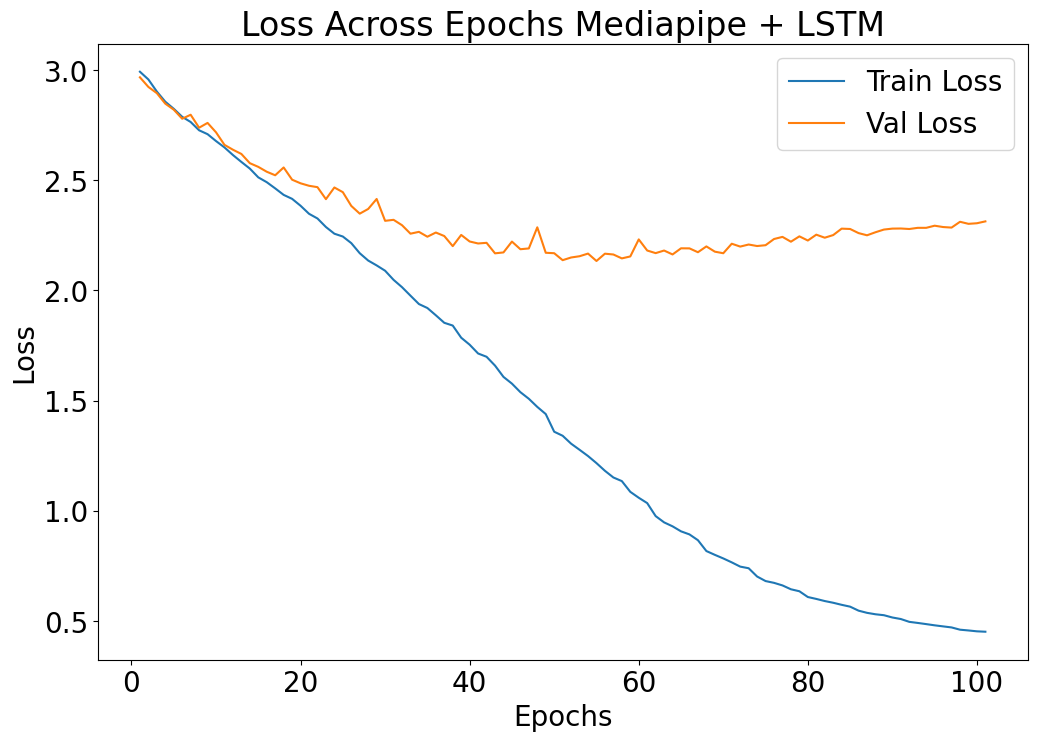

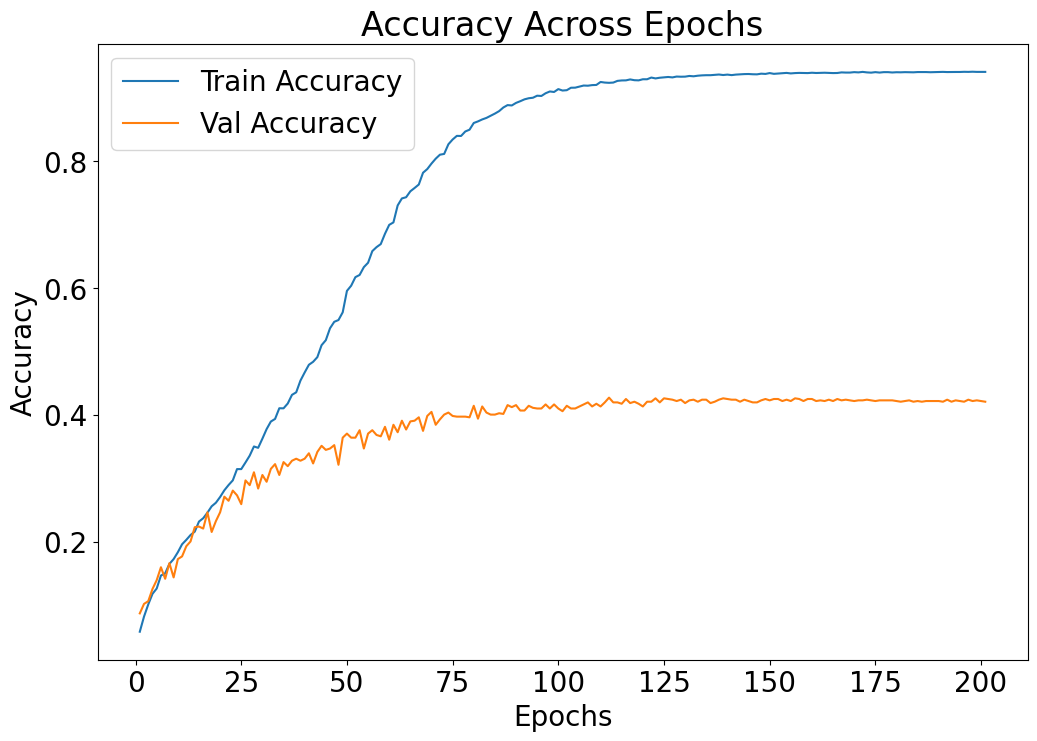

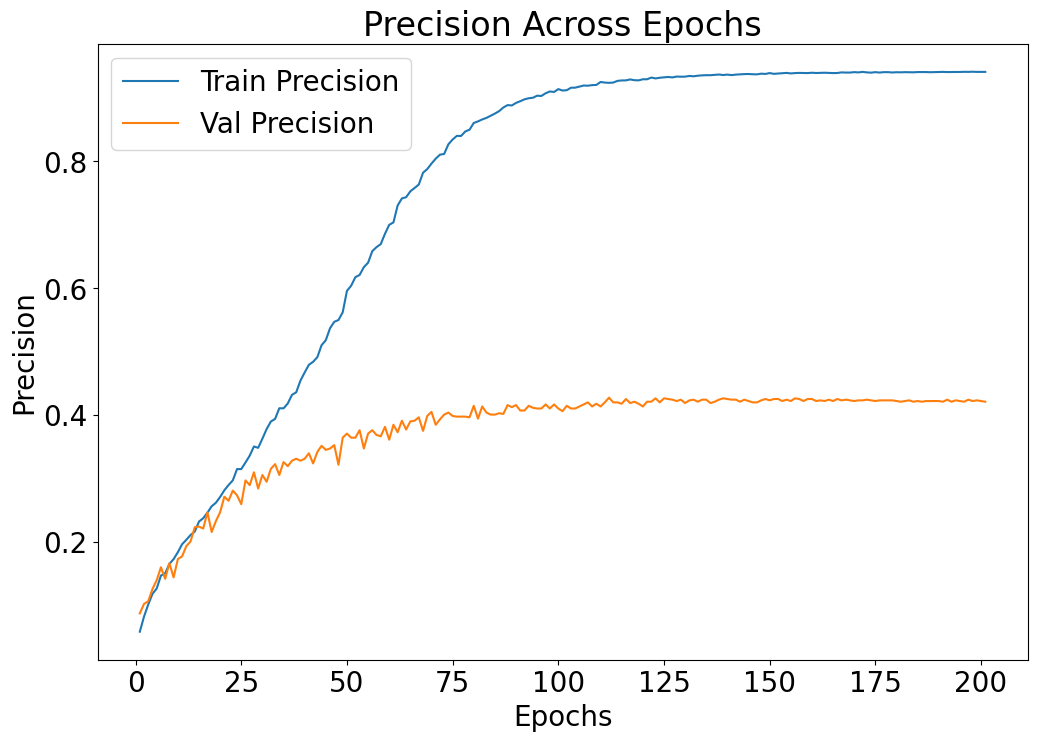

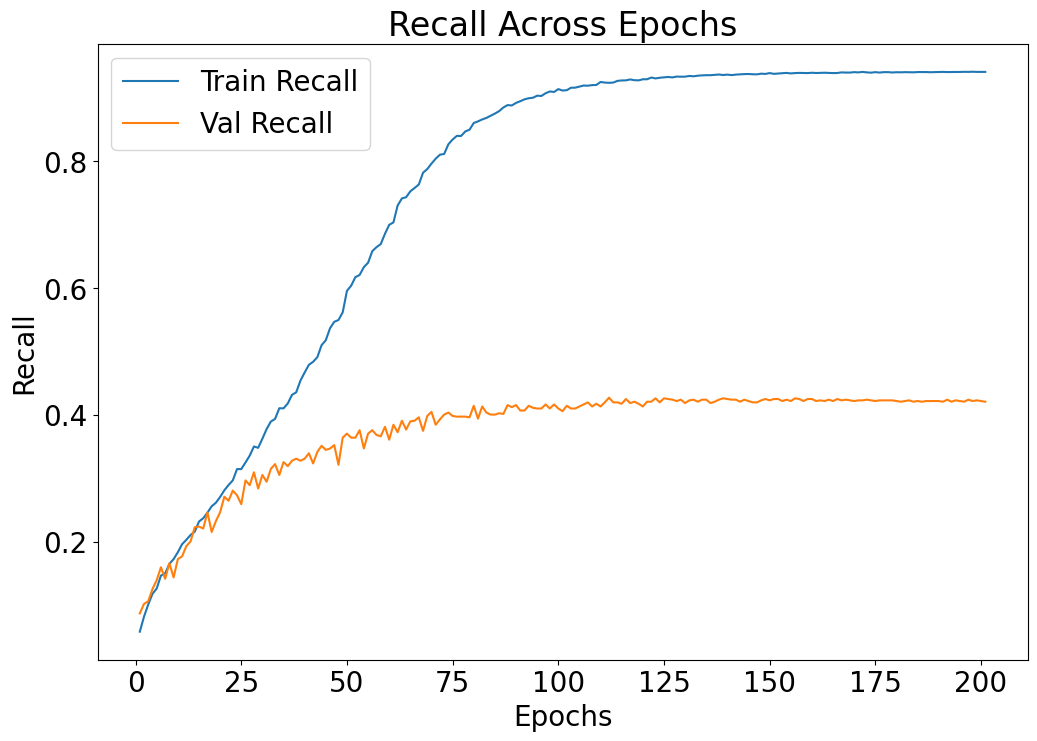

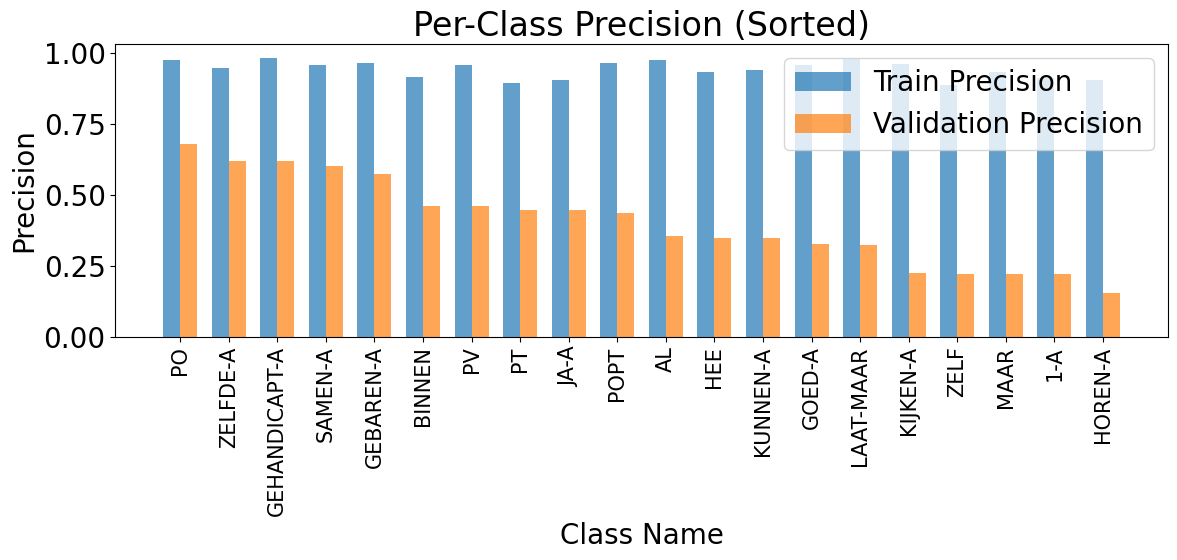

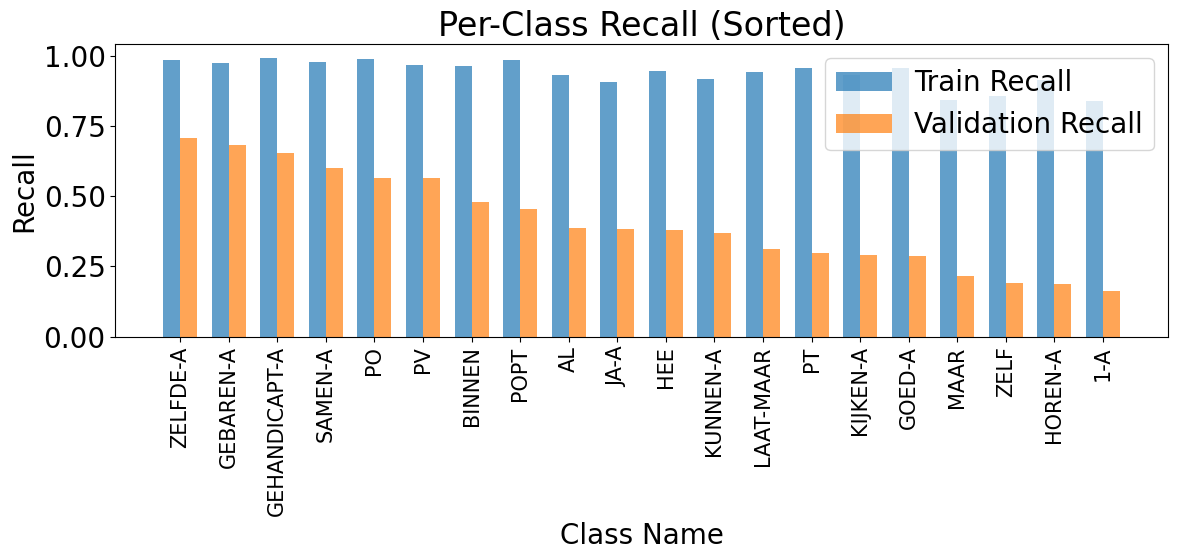

In [106]:
# Plotting results
# Plotting results for the first 101 epochs
epochs = range(1, 101 + 1)  # Ensure it doesn't exceed available epochs
plt.rcParams['font.size'] = 20

plt.figure(figsize=(12, 8))
plt.plot(epochs, train_loss[:101], label='Train Loss')  # Slice first 101 epochs
plt.plot(epochs, val_loss[:101], label='Val Loss')  # Slice first 101 epochs
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Across Epochs Mediapipe + ' + model_type)
plt.savefig(modelweights+'/Train-Val_Loss_First_101.png')
plt.show()

epochs = range(1, num_epochs + 1)

# Accuracy plot
plt.figure(figsize=(12, 8))
plt.plot(epochs, train_acc, label='Train Accuracy')
plt.plot(epochs, val_acc, label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Across Epochs')
plt.savefig(modelweights+'/Train-Val Accuracy.png')
plt.show()

# Precision plot
plt.figure(figsize=(12, 8))
plt.plot(epochs, train_precision, label='Train Precision')
plt.plot(epochs, val_precision, label='Val Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()
plt.title('Precision Across Epochs')
plt.savefig(modelweights+'/Train-Val Avg Precision.png')
plt.show()

# Recall plot
plt.figure(figsize=(12, 8))
plt.plot(epochs, train_recall, label='Train Recall')
plt.plot(epochs, val_recall, label='Val Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
plt.title('Recall Across Epochs')
plt.savefig(modelweights+'/Train-Val Avg Recall.png')
plt.show()

# Plot per-class precision as histograms
last_train_precision = train_precision_per_class[-1]
last_val_precision = val_precision_per_class[-1]

bar_width = 0.35
indices = np.arange(num_classes)

sorted_indices = np.argsort(last_val_precision)[::-1]  # Sort in descending order
sorted_train_precision = np.array(last_train_precision)[sorted_indices]
sorted_val_precision = np.array(last_val_precision)[sorted_indices]
reverse_dict = {v: k for k, v in labels_dict.items()}
sorted_labels = [reverse_dict[key] for key in sorted_indices]

plt.figure(figsize=(12, 6))
plt.bar(np.arange(len(sorted_indices)), sorted_train_precision, bar_width, label='Train Precision', alpha=0.7)
plt.bar(np.arange(len(sorted_indices)) + bar_width, sorted_val_precision, bar_width, label='Validation Precision', alpha=0.7)
plt.title('Per-Class Precision (Sorted)')
plt.xlabel('Class Index' if labels_dict is None else 'Class Name')
plt.ylabel('Precision')
plt.xticks(np.arange(len(sorted_indices)) + bar_width / 2, sorted_labels, rotation=90, fontsize=15)
plt.legend()
plt.tight_layout()
plt.savefig(modelweights+'/Train-Val Precision Per Class.png')
plt.show()

# Plot per-class recall as histograms
last_train_recall = train_recall_per_class[-1]
last_val_recall = val_recall_per_class[-1]

bar_width = 0.35
indices = np.arange(num_classes)

sorted_indices = np.argsort(last_val_recall)[::-1]  # Sort in descending order
sorted_train_recall = np.array(last_train_recall)[sorted_indices]
sorted_val_recall = np.array(last_val_recall)[sorted_indices]
reverse_dict = {v: k for k, v in labels_dict.items()}
sorted_labels = [reverse_dict[key] for key in sorted_indices]

plt.figure(figsize=(12, 6))
plt.bar(np.arange(len(sorted_indices)), sorted_train_recall, bar_width, label='Train Recall', alpha=0.7)
plt.bar(np.arange(len(sorted_indices)) + bar_width, sorted_val_recall, bar_width, label='Validation Recall', alpha=0.7)
plt.title('Per-Class Recall (Sorted)')
plt.xlabel('Class Index' if labels_dict is None else 'Class Name')
plt.ylabel('Recall')
plt.xticks(np.arange(len(sorted_indices)) + bar_width / 2, sorted_labels, rotation=90, fontsize=15)
plt.legend()
plt.tight_layout()
plt.savefig(modelweights+'/Train-Val Recall Per Class.png')
plt.show()

In [107]:
#Save metrics for later
import pickle

# Combine metrics into a dictionary
metrics = {
    "train_loss": train_loss,
    "val_loss": val_loss,
    "train_acc": train_acc,
    "val_acc": val_acc,
    "train_precision": train_precision,
    "val_precision": val_precision,
    "train_precision_per_class": train_precision_per_class,
    "val_precision_per_class": val_precision_per_class,
    "train_recall": train_recall,
    "val_recall": val_recall,
    "train_recall_per_class": train_recall_per_class,
    "val_recall_per_class": val_recall_per_class
}

# Save to a pickle file
with open(modelweights + "/" + "metrics.pkl", "wb") as f:
   pickle.dump(metrics, f)

# Load from the pickle file
with open(modelweights + "/" + "metrics.pkl", "rb") as f:
    loaded_metrics = pickle.load(f)

----------------------

## 6 TEST MODEL

Code needs to be changed to reflect the new keypoints data type

### Test Model 2.0

In [108]:
import torch
from tqdm import tqdm
import numpy as np

def test_model(model, test_loader, device, num_classes):
    model.eval()
    running_loss = 0.0
    correct_preds = 0
    total_preds = 0
    precision_per_class = np.zeros(num_classes)
    recall_per_class = np.zeros(num_classes)
    accuracy_per_class = np.zeros(num_classes)
    total_per_class = np.zeros(num_classes)
    correct_per_class = np.zeros(num_classes)

    criterion = torch.nn.CrossEntropyLoss()  # Assuming cross-entropy loss

    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="Testing"):
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Update running loss
            running_loss += loss.item() * inputs.size(0)

            # Compute predictions
            preds = torch.argmax(outputs, dim=1)
            correct_preds += (preds == labels).sum().item()
            total_preds += labels.size(0)

            # Compute per-class metrics
            overall_precision, class_precision, overall_recall, class_recall = calculate_metrics(preds, labels, num_classes)
            precision_per_class += class_precision
            recall_per_class += class_recall

            # Compute per-class accuracy
            for c in range(num_classes):
                total_per_class[c] += (labels == c).sum().item()
                correct_per_class[c] += ((preds == c) & (labels == c)).sum().item()

    # Calculate final metrics
    test_loss = running_loss / len(test_loader.dataset)
    test_acc = correct_preds / total_preds
    test_precision = precision_per_class.mean() / len(test_loader)
    test_recall = recall_per_class.mean() / len(test_loader)
    test_precision_per_class = precision_per_class / len(test_loader)
    test_recall_per_class = recall_per_class / len(test_loader)
    test_accuracy_per_class = correct_per_class / total_per_class
    average_test_precision_per_class = sum(test_precision_per_class) / num_classes
    average_test_recall_per_class = sum(test_recall_per_class) / num_classes
    average_test_accuracy_per_class = np.nanmean(test_accuracy_per_class)  # Avoid division by zero issues

    print(f"Test Summary:")
    print(f"Test Loss: {test_loss:.4f}, Accuracy: {test_acc:.4f}, Precision: {test_precision:.4f}, Recall: {test_recall:.4f}")
    print(f"Per-Class Precision: {test_precision_per_class}")
    print(f"Per-Class Recall: {test_recall_per_class}")
    print(f"Per-Class Accuracy: {test_accuracy_per_class}")

    return test_loss, test_acc, test_precision, test_precision_per_class, average_test_precision_per_class, \
           test_recall, test_recall_per_class, average_test_recall_per_class, test_accuracy_per_class, average_test_accuracy_per_class


In [109]:
epoch = "80"

# Choose which epoch of model weights we want to test
path_to_model_weights = modelweights + "/epoch" + epoch

# Load best model weights
model.load_state_dict(torch.load(path_to_model_weights))

# Test the model
test_loss, test_acc, test_precision, test_precision_per_class, average_test_precision_per_class, \
           test_recall, test_recall_per_class, average_test_recall_per_class, test_accuracy_per_class, average_test_accuracy_per_class = test_model(
    model, test_dl, device, num_classes)

Testing: 100%|██████████| 30/30 [00:03<00:00,  8.41it/s]

Test Summary:
Test Loss: 2.3839, Accuracy: 0.3814, Precision: 0.3023, Recall: 0.3048
Per-Class Precision: [0.10277778 0.15222222 0.27444444 0.45333334 0.48388889 0.30555556
 0.23888889 0.28055556 0.27055556 0.12055556 0.24444445 0.34833334
 0.21111111 0.52444445 0.36055556 0.295      0.44444444 0.35
 0.16611111 0.41777778]
Per-Class Recall: [0.07888889 0.12777778 0.275      0.49111111 0.53666667 0.32055556
 0.24166667 0.31111111 0.22       0.14444444 0.22777778 0.28833334
 0.20555556 0.56666667 0.32888889 0.35       0.39444445 0.29444444
 0.21388889 0.47833333]
Per-Class Accuracy: [0.11904762 0.26190476 0.45454545 0.64583333 0.69565217 0.33898305
 0.32653061 0.34       0.36170213 0.15555556 0.25       0.35849057
 0.2        0.64583333 0.43396226 0.36363636 0.54285714 0.34
 0.23255814 0.57777778]


In [113]:
import pickle

test_metrics = {
    "test_loss": test_loss,
    "test_acc": test_acc,
    "test_precision": test_precision,
    "test_precision_per_class": test_precision_per_class,
    "average_test_precision_per_class": average_test_precision_per_class,
    "test_recall": test_recall,
    "test_recall_per_class": test_recall_per_class,
    "average_test_recall_per_class": average_test_recall_per_class,
    "test_accuracy_per_class": test_accuracy_per_class,  # Added accuracy per class
    "average_test_accuracy_per_class": sum(test_accuracy_per_class) / num_classes  # Average accuracy per class
}

# Save to a pickle file
with open(modelweights + "/" + "test_metrics" + str(epoch) + ".pkl", "wb") as f:
    pickle.dump(test_metrics, f)

# Load and verify the saved data
with open(modelweights + "/" + "test_metrics" + str(epoch) + ".pkl", "rb") as f:
    test_loaded_metrics = pickle.load(f)

print("Loaded Metrics:", test_loaded_metrics)


Loaded Metrics: {'test_loss': 2.3838565166179952, 'test_acc': 0.3814102564102564, 'test_precision': np.float64(0.3022500013311704), 'test_precision_per_class': array([0.10277778, 0.15222222, 0.27444444, 0.45333334, 0.48388889,
       0.30555556, 0.23888889, 0.28055556, 0.27055556, 0.12055556,
       0.24444445, 0.34833334, 0.21111111, 0.52444445, 0.36055556,
       0.295     , 0.44444444, 0.35      , 0.16611111, 0.41777778]), 'average_test_precision_per_class': np.float64(0.3022500013311703), 'test_recall': np.float64(0.30477777905762193), 'test_recall_per_class': array([0.07888889, 0.12777778, 0.275     , 0.49111111, 0.53666667,
       0.32055556, 0.24166667, 0.31111111, 0.22      , 0.14444444,
       0.22777778, 0.28833334, 0.20555556, 0.56666667, 0.32888889,
       0.35      , 0.39444445, 0.29444444, 0.21388889, 0.47833333]), 'average_test_recall_per_class': np.float64(0.304777779057622), 'test_accuracy_per_class': array([0.11904762, 0.26190476, 0.45454545, 0.64583333, 0.69565217,
 

In [114]:
def f1_score(precision, recall):
    if precision + recall == 0:
        return 0  # Avoid division by zero
    return 2 * (precision * recall) / (precision + recall)

# Example values
precision = 0.8
recall = 0.75

f1 = f1_score(test_precision, test_recall)
print("F1-score:", f1)


F1-score: 0.3035086271237092


## 7 TEST MODEL Random Selector


In [117]:
import torch
from tqdm import tqdm
import numpy as np

def test_random_baseline(test_loader, device, num_classes):
    running_loss = 0.0
    correct_preds = 0
    total_preds = 0
    precision_per_class = np.zeros(num_classes)
    recall_per_class = np.zeros(num_classes)
    accuracy_per_class = np.zeros(num_classes)
    total_per_class = np.zeros(num_classes)
    correct_per_class = np.zeros(num_classes)

    criterion = torch.nn.CrossEntropyLoss()  # Assuming cross-entropy loss

    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="Testing Random Baseline"):
            labels = labels.to(device)

            # Generate random predictions
            batch_size = labels.size(0)
            random_preds = torch.randint(0, num_classes, (batch_size,), device=device)

            # Compute loss (random predictions vs. actual labels)
            loss = criterion(torch.randn(batch_size, num_classes, device=device), labels)  # Use random logits

            # Update running loss
            running_loss += loss.item() * batch_size

            # Compute accuracy
            correct_preds += (random_preds == labels).sum().item()
            total_preds += batch_size

            # Compute per-class metrics
            overall_precision, class_precision, overall_recall, class_recall = calculate_metrics(random_preds, labels, num_classes)
            precision_per_class += class_precision
            recall_per_class += class_recall

            # Compute per-class accuracy
            for c in range(num_classes):
                total_per_class[c] += (labels == c).sum().item()
                correct_per_class[c] += ((random_preds == c) & (labels == c)).sum().item()

    # Calculate final metrics
    test_loss = running_loss / len(test_loader.dataset)
    test_acc = correct_preds / total_preds
    test_precision = precision_per_class.mean() / len(test_loader)
    test_recall = recall_per_class.mean() / len(test_loader)
    test_precision_per_class = precision_per_class / len(test_loader)
    test_recall_per_class = recall_per_class / len(test_loader)
    test_accuracy_per_class = correct_per_class / total_per_class
    average_test_precision_per_class = sum(test_precision_per_class) / num_classes
    average_test_recall_per_class = sum(test_recall_per_class) / num_classes
    average_test_accuracy_per_class = np.nanmean(test_accuracy_per_class)  # Avoid division by zero issues

    print(f"Test Summary:")
    print(f"Test Loss: {test_loss:.4f}, Accuracy: {test_acc:.4f}, Precision: {test_precision:.4f}, Recall: {test_recall:.4f}")
    print(f"Per-Class Precision: {test_precision_per_class}")
    print(f"Per-Class Recall: {test_recall_per_class}")
    print(f"Per-Class Accuracy: {test_accuracy_per_class}")

    return test_loss, test_acc, test_precision, test_precision_per_class, average_test_precision_per_class, \
           test_recall, test_recall_per_class, average_test_recall_per_class, test_accuracy_per_class, average_test_accuracy_per_class


In [118]:
# Test the model
random_test_loss, random_test_acc, random_test_precision, random_test_precision_per_class, random_average_test_precision_per_class, random_test_recall, \
random_test_recall_per_class, random_average_test_recall_per_class, random_test_accuracy_per_class, random_average_test_accuracy_per_class = test_random_baseline(
    test_dl, device, num_classes
)

Testing Random Baseline: 100%|██████████| 30/30 [00:03<00:00,  8.42it/s]

Test Summary:
Test Loss: 3.4366, Accuracy: 0.0598, Precision: 0.0527, Recall: 0.0460
Per-Class Precision: [0.03611111 0.01111111 0.09444444 0.11666667 0.         0.10833333
 0.04444444 0.03333333 0.10555556 0.07777778 0.03333333 0.04
 0.09444444 0.07777778 0.04444444 0.03611111 0.01111111 0.05
 0.01666667 0.02222222]
Per-Class Recall: [0.03055556 0.01111111 0.11111111 0.04722222 0.         0.08055556
 0.03611111 0.03333333 0.065      0.04833333 0.00833333 0.08333333
 0.05555556 0.08333333 0.02333333 0.03611111 0.01666667 0.08333333
 0.03333333 0.03333333]
Per-Class Accuracy: [0.07142857 0.02380952 0.15151515 0.08333333 0.         0.10169492
 0.06122449 0.04       0.10638298 0.06666667 0.02083333 0.05660377
 0.08888889 0.0625     0.03773585 0.05454545 0.02857143 0.08
 0.02325581 0.04444444]


In [122]:
random_test_metrics = {
    "test_loss": random_test_loss,
    "test_acc": random_test_acc,
    "test_precision": random_test_precision,
    "test_precision_per_class": random_test_precision_per_class,
    "average_test_precision_per_class": random_average_test_precision_per_class,
    "test_recall": random_test_recall,
    "test_recall_per_class": random_test_recall_per_class,
    "average_test_recall_per_class": random_average_test_recall_per_class,
    "test_accuracy_per_class": random_test_accuracy_per_class,  # NEW: Per-class accuracy
    "average_test_accuracy_per_class": np.mean(random_test_accuracy_per_class)  # NEW: Average per-class accuracy
}

# Save to a pickle file
with open(modelweights + "/" + "random_test_metrics" + epoch + ".pkl", "wb") as f:
    pickle.dump(random_test_metrics, f)

# Load the pickle file to verify
with open(modelweights + "/" + "random_test_metrics" + epoch + ".pkl", "rb") as f:
    random_test_loaded_metrics = pickle.load(f)

# Verify the loaded data
print("Loaded Metrics:", random_test_loaded_metrics)


Loaded Metrics: {'test_loss': 3.436554171081282, 'test_acc': 0.05982905982905983, 'test_precision': np.float64(0.052694444755713145), 'test_precision_per_class': array([0.03611111, 0.01111111, 0.09444444, 0.11666667, 0.        ,
       0.10833333, 0.04444444, 0.03333333, 0.10555556, 0.07777778,
       0.03333333, 0.04      , 0.09444444, 0.07777778, 0.04444444,
       0.03611111, 0.01111111, 0.05      , 0.01666667, 0.02222222]), 'average_test_precision_per_class': np.float64(0.05269444475571315), 'test_recall': np.float64(0.04600000021358331), 'test_recall_per_class': array([0.03055556, 0.01111111, 0.11111111, 0.04722222, 0.        ,
       0.08055556, 0.03611111, 0.03333333, 0.065     , 0.04833333,
       0.00833333, 0.08333333, 0.05555556, 0.08333333, 0.02333333,
       0.03611111, 0.01666667, 0.08333333, 0.03333333, 0.03333333]), 'average_test_recall_per_class': np.float64(0.04600000021358332), 'test_accuracy_per_class': array([0.07142857, 0.02380952, 0.15151515, 0.08333333, 0.      

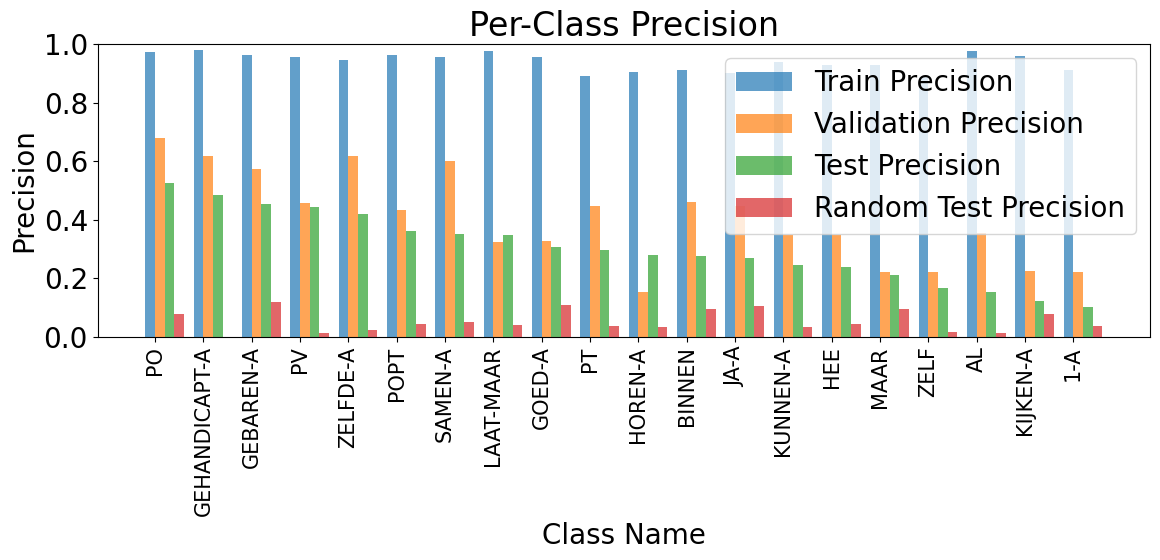

In [123]:
# Plot per-class precision as histograms
last_train_precision = train_precision_per_class[-1]
last_val_precision = val_precision_per_class[-1]
last_test_precision = test_precision_per_class
last_random_test_precision = random_test_precision_per_class

bar_width = 0.20
indices = np.arange(num_classes)

sorted_indices = np.argsort(test_precision_per_class)[::-1]  # Sort in descending order
sorted_train_precision = np.array(last_train_precision)[sorted_indices]
sorted_val_precision = np.array(last_val_precision)[sorted_indices]
sorted_test_precision = np.array(last_test_precision)[sorted_indices]
sorted_random_test_precision = np.array(last_random_test_precision)[sorted_indices]
reverse_dict = {v: k for k, v in labels_dict.items()}
sorted_labels = [reverse_dict[key] for key in sorted_indices]

plt.figure(figsize=(12, 6))
plt.bar(np.arange(len(sorted_indices)), sorted_train_precision, bar_width, label='Train Precision', alpha=0.7)
plt.bar(np.arange(len(sorted_indices)) + bar_width, sorted_val_precision, bar_width, label='Validation Precision', alpha=0.7)
plt.bar(np.arange(len(sorted_indices)) + 2*bar_width, sorted_test_precision, bar_width, label='Test Precision', alpha=0.7)
plt.bar(np.arange(len(sorted_indices)) + 3*bar_width, sorted_random_test_precision, bar_width, label='Random Test Precision', alpha=0.7)
plt.title('Per-Class Precision')
plt.xlabel('Class Index' if labels_dict is None else 'Class Name')
plt.ylabel('Precision')
plt.ylim(0, 1)
plt.xticks(np.arange(len(sorted_indices)) + bar_width / 2, sorted_labels, rotation=90, fontsize=15)
plt.legend()
plt.tight_layout()
plt.savefig(modelweights+'/RANDOM Train-Val-Test Precision Per Class'+epoch+'.png')
plt.show()

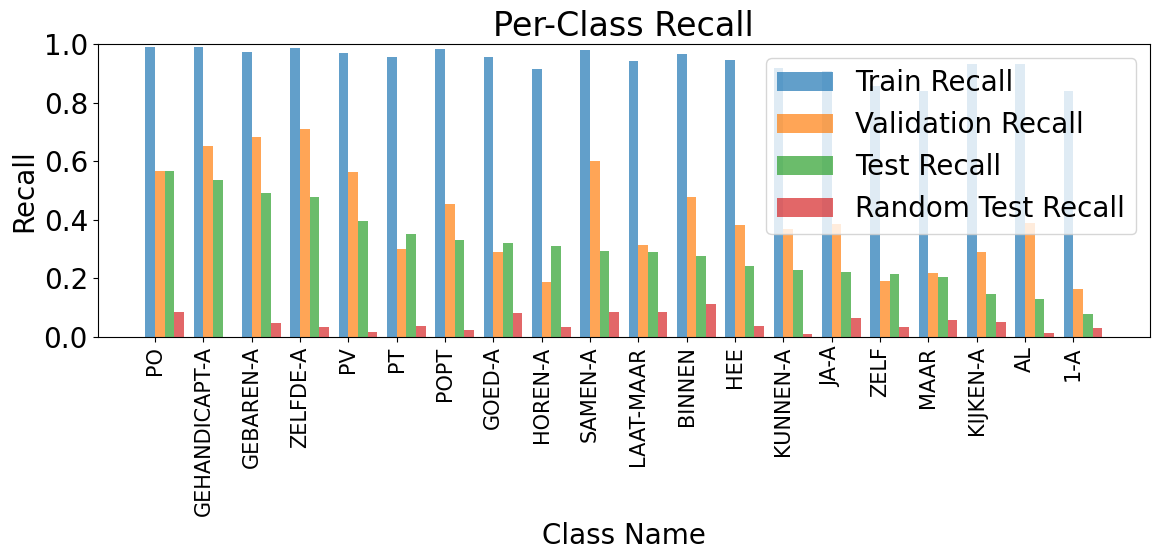

In [124]:
# Plot per-class recall as histograms
last_train_recall = train_recall_per_class[-1]
last_val_recall = val_recall_per_class[-1]
last_test_recall = test_recall_per_class
last_random_test_recall = random_test_recall_per_class

bar_width = 0.20
indices = np.arange(num_classes)

sorted_indices = np.argsort(test_recall_per_class)[::-1]  # Sort in descending order
sorted_train_recall = np.array(last_train_recall)[sorted_indices]
sorted_val_recall = np.array(last_val_recall)[sorted_indices]
sorted_test_recall = np.array(last_test_recall)[sorted_indices]
sorted_random_test_recall = np.array(last_random_test_recall)[sorted_indices]
reverse_dict = {v: k for k, v in labels_dict.items()}
sorted_labels = [reverse_dict[key] for key in sorted_indices]

plt.figure(figsize=(12, 6))
plt.bar(np.arange(len(sorted_indices)), sorted_train_recall, bar_width, label='Train Recall', alpha=0.7)
plt.bar(np.arange(len(sorted_indices)) + bar_width, sorted_val_recall, bar_width, label='Validation Recall', alpha=0.7)
plt.bar(np.arange(len(sorted_indices)) + 2*bar_width, sorted_test_recall, bar_width, label='Test Recall', alpha=0.7)
plt.bar(np.arange(len(sorted_indices)) + 3*bar_width, sorted_random_test_recall, bar_width, label='Random Test Recall', alpha=0.7)
plt.title('Per-Class Recall')
plt.xlabel('Class Index' if labels_dict is None else 'Class Name')
plt.ylabel('Recall')
plt.ylim(0, 1)
plt.xticks(np.arange(len(sorted_indices)) + bar_width / 2, sorted_labels, rotation=90, fontsize=15)
plt.legend()
plt.tight_layout()
plt.savefig(modelweights+'/RANDOM Train-Val-Test Recall Per Class'+epoch+'.png')
plt.show()

Testing: 100%|██████████| 30/30 [00:03<00:00,  8.54it/s]


Test Summary:
Test Loss: 2.4755, Accuracy: 0.3771, Precision: 0.3009, Recall: 0.2962
Per-Class Precision: [0.125      0.19888889 0.25222222 0.49444445 0.43166667 0.33611111
 0.24       0.30833334 0.25888889 0.165      0.17777778 0.32611111
 0.21666667 0.52222222 0.37722223 0.31722222 0.43333333 0.33444444
 0.13888889 0.36388889]
Per-Class Recall: [0.09       0.19444445 0.26111111 0.49111111 0.44666667 0.33166667
 0.20833333 0.33888889 0.23666667 0.15777778 0.21388889 0.28833334
 0.20555556 0.58333333 0.34555556 0.36666667 0.41111111 0.25555556
 0.13055556 0.36722222]
Per-Class Accuracy: {0: np.float64(0.14285714285714285), 1: np.float64(0.30952380952380953), 2: np.float64(0.42424242424242425), 3: np.float64(0.6458333333333334), 4: np.float64(0.6086956521739131), 5: np.float64(0.3559322033898305), 6: np.float64(0.2857142857142857), 7: np.float64(0.38), 8: np.float64(0.3829787234042553), 9: np.float64(0.2), 10: np.float64(0.22916666666666666), 11: np.float64(0.3584905660377358), 12: np.f

Testing Random Baseline: 100%|██████████| 30/30 [00:03<00:00,  8.66it/s]


Test Summary:
Test Loss: 3.5143, Accuracy: 0.0534, Precision: 0.0397, Recall: 0.0410
Per-Class Precision: [0.065      0.01666667 0.         0.01111111 0.03333333 0.03333333
 0.06944444 0.03055556 0.05833333 0.03611111 0.06777778 0.03333333
 0.01666667 0.06666667 0.08888889 0.04444445 0.01111111 0.06666667
 0.01666667 0.02777778]
Per-Class Recall: [0.06777778 0.01666667 0.         0.01111111 0.04166667 0.00666667
 0.04722222 0.03611111 0.09444444 0.03166667 0.07222222 0.01666667
 0.03333333 0.1        0.04166667 0.05833333 0.03333333 0.05
 0.01666667 0.04444444]
Per-Class Accuracy: {0: np.float64(0.09523809523809523), 1: np.float64(0.023809523809523808), 2: np.float64(0.0), 3: np.float64(0.020833333333333332), 4: np.float64(0.06521739130434782), 5: np.float64(0.01694915254237288), 6: np.float64(0.08163265306122448), 7: np.float64(0.06), 8: np.float64(0.10638297872340426), 9: np.float64(0.06666666666666667), 10: np.float64(0.08333333333333333), 11: np.float64(0.018867924528301886), 12: n

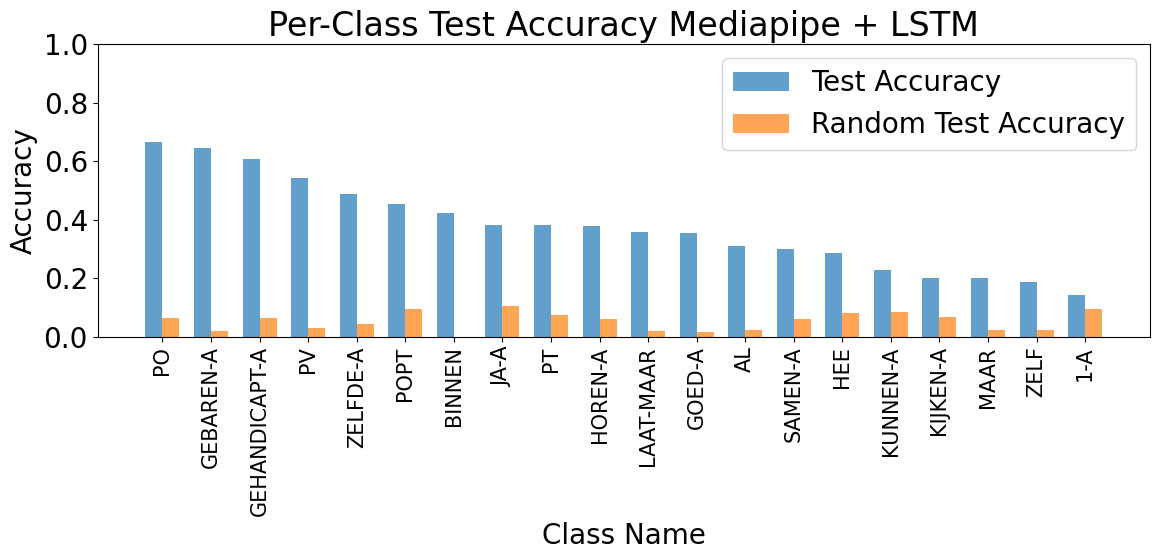

In [127]:
import torch
from tqdm import tqdm
import numpy as np

def test(test_loader, device, num_classes, random_baseline=False):
    """
    Perform evaluation on either a trained model or a random baseline.

    Args:
        test_loader: DataLoader for test set
        device: The device on which the model should run (e.g., 'cuda' or 'cpu')
        num_classes: Number of classes
        model: The trained model (only needed for non-random evaluation)
        random_baseline: Boolean flag to use a random baseline instead of the model

    Returns:
        test_loss: The average loss during testing
        test_acc: The overall accuracy during testing
        test_precision: The average precision across all classes
        test_precision_per_class: Precision per class
        average_test_precision_per_class: Average precision across classes
        test_recall: The average recall across all classes
        test_recall_per_class: Recall per class
        average_test_recall_per_class: Average recall across classes
        test_accuracy_per_class_dict: Accuracy per class as a dictionary
        average_test_accuracy_per_class: Average accuracy across classes
    """
    running_loss = 0.0
    correct_preds = 0
    total_preds = 0
    precision_per_class = np.zeros(num_classes)
    recall_per_class = np.zeros(num_classes)
    total_per_class = np.zeros(num_classes)
    correct_per_class = np.zeros(num_classes)

    criterion = torch.nn.CrossEntropyLoss()  # Assuming cross-entropy loss

    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="Testing" if not random_baseline else "Testing Random Baseline"):
            inputs, labels = inputs.to(device), labels.to(device)

            if random_baseline:
                # Generate random predictions for random baseline
                batch_size = labels.size(0)
                random_preds = torch.randint(0, num_classes, (batch_size,), device=device)
                loss = criterion(torch.randn(batch_size, num_classes, device=device), labels)  # Use random logits
            else:
                # Use the model to make predictions
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                random_preds = torch.argmax(outputs, dim=1)  # Predicted labels using the model

            # Update running loss
            running_loss += loss.item() * inputs.size(0)

            # Compute accuracy
            correct_preds += (random_preds == labels).sum().item()
            total_preds += labels.size(0)

            # Compute per-class metrics
            overall_precision, class_precision, overall_recall, class_recall = calculate_metrics(random_preds, labels, num_classes)
            precision_per_class += class_precision
            recall_per_class += class_recall

            # Compute per-class accuracy
            for c in range(num_classes):
                total_per_class[c] += (labels == c).sum().item()
                correct_per_class[c] += ((random_preds == c) & (labels == c)).sum().item()

    # Calculate final metrics
    test_loss = running_loss / len(test_loader.dataset)
    test_acc = correct_preds / total_preds
    test_precision = precision_per_class.mean() / len(test_loader)
    test_recall = recall_per_class.mean() / len(test_loader)
    test_precision_per_class = precision_per_class / len(test_loader)
    test_recall_per_class = recall_per_class / len(test_loader)
    
    # Calculate per-class accuracy as a dictionary
    test_accuracy_per_class_dict = {i: correct_per_class[i] / total_per_class[i] if total_per_class[i] > 0 else 0 
                                    for i in range(num_classes)}
    
    average_test_precision_per_class = sum(test_precision_per_class) / num_classes
    average_test_recall_per_class = sum(test_recall_per_class) / num_classes
    average_test_accuracy_per_class = np.nanmean([test_accuracy_per_class_dict[i] for i in range(num_classes)])  # Avoid division by zero issues

    print(f"Test Summary:")
    print(f"Test Loss: {test_loss:.4f}, Accuracy: {test_acc:.4f}, Precision: {test_precision:.4f}, Recall: {test_recall:.4f}")
    print(f"Per-Class Precision: {test_precision_per_class}")
    print(f"Per-Class Recall: {test_recall_per_class}")
    print(f"Per-Class Accuracy: {test_accuracy_per_class_dict}")

    return test_loss, test_acc, test_precision, test_precision_per_class, average_test_precision_per_class, \
           test_recall, test_recall_per_class, average_test_recall_per_class, test_accuracy_per_class_dict, average_test_accuracy_per_class

epoch = "100"

# Choose which epoch of model weights we want to test
path_to_model_weights = modelweights + "/epoch" + epoch

# Load best model weights
model.load_state_dict(torch.load(path_to_model_weights))

# Test the model
test_loss, test_acc, test_precision, test_precision_per_class, average_test_precision_per_class, \
           test_recall, test_recall_per_class, average_test_recall_per_class, test_accuracy_per_class, average_test_accuracy_per_class = test(test_dl, device, num_classes, random_baseline=False)

# Test the model
random_test_loss, random_test_acc, random_test_precision, random_test_precision_per_class, random_average_test_precision_per_class, random_test_recall, \
random_test_recall_per_class, random_average_test_recall_per_class, random_test_accuracy_per_class, random_average_test_accuracy_per_class = test(test_dl, device, num_classes, random_baseline=True)




import matplotlib.pyplot as plt
import numpy as np

# Assuming last_test_accuracy is a dictionary with class index as keys and accuracy as values
last_test_accuracy = test_accuracy_per_class  # This is now a dict
random_last_test_accuracy = random_test_accuracy_per_class  # This is also a dict

bar_width = 0.35
indices = np.arange(len(last_test_accuracy))  # Length of the dictionary

# Sort the dictionary based on accuracy (values) in descending order
sorted_accuracy = {k: v for k, v in sorted(last_test_accuracy.items(), key=lambda item: item[1], reverse=True)}
sorted_random_accuracy = {k: v for k, v in sorted(random_last_test_accuracy.items(), key=lambda item: item[1], reverse=True)}

# Extract sorted indices and accuracies
sorted_indices = list(sorted_accuracy.keys())  # Sorted class indices based on accuracy
sorted_test_accuracy = list(sorted_accuracy.values())  # Sorted test accuracies
sorted_random_test_accuracy = [sorted_random_accuracy[i] for i in sorted_indices]  # Align random accuracy with sorted indices

# Reverse the dictionary to map indices to labels
reverse_dict = {v: k for k, v in labels_dict.items()}
sorted_labels = [reverse_dict[key] for key in sorted_indices]

# Plotting the data
plt.figure(figsize=(12, 6))
plt.bar(np.arange(len(sorted_indices)), sorted_test_accuracy, bar_width, label='Test Accuracy', alpha=0.7)
plt.bar(np.arange(len(sorted_indices)) + bar_width, sorted_random_test_accuracy, bar_width, label='Random Test Accuracy', alpha=0.7)
plt.title('Per-Class Test Accuracy Mediapipe + ' + model_type)
plt.xlabel('Class Index' if labels_dict is None else 'Class Name')
plt.ylabel('Accuracy')
plt.ylim(0, 1)

# Update x-axis labels with class names if labels_dict is available
plt.xticks(np.arange(len(sorted_indices)) + bar_width / 2, sorted_labels, rotation=90, fontsize=15)

plt.legend()
plt.tight_layout()
plt.savefig(modelweights+'/RANDOM Test Accuracy Per Class'+epoch+'.png')
plt.show()